In [37]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl

from matplotlib.gridspec import GridSpec
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter

algorithm = 'mnb'
acc = ''
file_name = './models/'+algorithm.upper()+'_model_'+acc

year = "2021"
month = "november"
dataset = pd.read_csv(f'./{year}-data/covid-{month}.csv', delimiter=',')


In [38]:

# removing the unnecessary columns.
dataset = dataset[['sentiment','tweet']]

with open(file_name, 'rb') as f:
    model = pickle.load(f)

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

tfidf = pickle.load(open(f"./vector/tfidf_{algorithm}_{acc}","rb"))

X = dataset['tweet'].fillna(' ')

tweets = X

y_pred = tfidf.transform(X)


In [39]:

predictions = model.predict(y_pred)

print(type(predictions))
print(model.predict_proba(y_pred))

<class 'numpy.ndarray'>
[[0.62598099 0.37401901]
 [0.32331803 0.67668197]
 [0.66716703 0.33283297]
 ...
 [0.37316343 0.62683657]
 [0.32331803 0.67668197]
 [0.56725053 0.43274947]]


In [40]:
altered_predictions = []

for prediction in model.predict_proba(y_pred):
    pos_sentiment = float(prediction[1])
    if pos_sentiment > 0.45 and pos_sentiment < 0.55:
        altered_predictions.append('neutral')
    elif pos_sentiment > 0.55:
        altered_predictions.append('positive')
    else:
        altered_predictions.append('negative')
        
# print(altered_predictions)
test = np.array([[x] for x in altered_predictions])
print(type(test))

<class 'numpy.ndarray'>


In [41]:

# saving tweets to csv
tweets.to_csv(f'./analysis/tweets-{month}-{year}.csv')
# saving sentiment predictions to csv
np.savetxt(f'./analysis/predictions-{month}-{year}.csv',altered_predictions, delimiter=',', fmt=('%s'))

DATASET_COLUMNS  = ["sentiment"]

# adding sentiment column to the beginning
df = pd.read_csv(f'./analysis/predictions-{month}-{year}.csv', header=None)
df.rename(columns={0: 'sentiment'}, inplace=True)
df.to_csv(f'./analysis/predictions-{month}-{year}.csv', index=False) # save to new csv file


In [42]:

# merging tweets and predictions
filenames = [f'./analysis/tweets-{month}-{year}.csv', f'./analysis/predictions-{month}-{year}.csv']
dfs = []
for filename in filenames:
    # read the csv, making sure the first two columns are str
    df = pd.read_csv(filename, header=None, converters={0: str, 1: str})
    # change the column names so they won't collide during concatenation
    df.columns = [filename + str(cname) for cname in df.columns]
    dfs.append(df)

# concatenate them horizontally
merged = pd.concat(dfs,axis=1)
# write it out
merged.to_csv(f"./analysis/merged-{month}-{year}.csv", header=None, index=None)


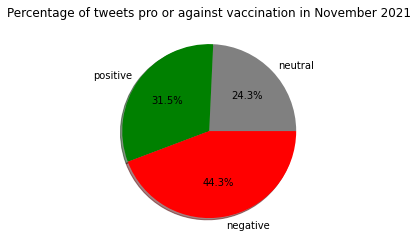

In [45]:

df = pd.read_csv(f'./analysis/merged-{month}-{year}.csv')

labels = ['negative', 'neutral', 'positive']

title_type = df.groupby('sentiment').agg('count')

type_labels = ['neutral', 'positive', 'negative']
type_counts = title_type.tweet.sort_values()

colors = ['grey', 'g', 'r']

plt.subplot(aspect=1, title=f'Percentage of tweets pro or against vaccination in {month.capitalize()} {year}')
type_show_ids = plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()
